In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
from multiprocessing import Pool
from random import randint
from typing import Any, Dict, List, Sequence
import time

import numpy.typing as npt
!pip install scaaml
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix



/opt/anaconda3/envs/DAT255_SCA_ny/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from typing import Sequence, List
import numpy.typing as npt


def pretty_hex(e: int) -> str:
    """Representation of an integer as a zero-padded two-digit hex string."""
    return f"{e:02X}"


def hex_line(chars: Sequence[int], spacer: str = " ") -> str:
    """Render some chars as hex with a spacer between them"""
    h = []
    for e in chars:
        h.append(pretty_hex(e))
    return spacer.join(h)


def hex_display(lst: Sequence[int],
                prefix: str = "",
                color: str = "green") -> None:
    """Display a list of int as colored hex."""
    h = []
    for e in lst:
        h.append(pretty_hex(e))
    hex_representation = prefix + " ".join(h)
    # Assuming you print with some styled color effect
    print(f"{color}: {hex_representation}")  # Example use of the 'color' parameter

def from_categorical(predictions: Sequence[npt.ArrayLike]) -> List[np.intp]:
    "reverse of categorical"
    # note: doing it as a list is significantly faster than a single argmax
    return [np.argmax(p) for p in predictions]


In [5]:
ATTACK_POINT = 'sub_bytes_in'

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 0

In [6]:
import src.DAT255_SCA.utils.dataset_utils as utils
file_path = "testing_set.hdf5"
utils.close_file(file_path)
utils.create_dataset(file_path, 256,256, "test")

(65536, 16) (65536, 16)
[123 212  64 231 103 136  38 171 145  68 207 235  35  71 173  84]
[ 57 170 230  85  32 242 235  10  99 189  98  40 225  24  61 217]
[ 47 214  59 232 208  22  62  83 138 221  47  92 206 241  13 118]
[132  65 255  97 221 147 136  97 217  64 182  99  42 111 243  52]
[ 33 188 221  61  64  65  13   2 252  35  43 119 169 249 255 142]
[ 10 237 180  30 186  96 132 210 183 235 100 223  65 248  95   5]
[128 137   5 179  72  29 220 164 156  74 162  96 156 122 157 103]
[178  53  92 191 224  26 135  11 110 111 196   0 238 112 229 227]
[  3 148 235  69 253 232  20  17 149 214 190 165 158 194  64 171]
[223  90   6  89 168 186  44 103 113 223  91 149 233  15 118  17]
[156 187  61   4  39  31 229 142 230   3 233  30 167  55  82  25]
[ 84 113 229 169 126  52 252 101  69 243 176 134 218  97 228 153]
[237  26 162 254 142 184 116  30 139 120   5 252 251 252 102  91]
[120 160 231 238  10 103  65 167  96 240  19 240 106  36  84  14]
[ 20  68 199  38  60 240 108  56 106  94 231 102  37

In [18]:

#importing the models
from keras.models import Model
import tensorflow as tf

model5000 = tf.keras.models.load_model("stm32f0-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_5000.keras")
model = tf.keras.models.load_model("first_scaaml_model_on_our_data.keras")
#no use for this as our data only has range 5000
#model20000 = tf.keras.models.load_model("stm32f0-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_20000.keras")

In [19]:
import src.DAT255_SCA.utils.dataset_utils as utils
NUM_TRACES = 40  # maximum number of traces to use to recover a given key byte. 10 is already overkill
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
file_path = "test_0.hdf5"

#for løkken må endres fordi metoden returnerer en liste av alt
#heller iterere over i, siden første plassen i listen er all info for "shard 1"
arr = np.zeros(256, dtype=int)
x = []
y = []
keys = []
pts = []

x, y, keys, pts = utils.load_and_prepare_dataset_for_evaluation(file_path, ATTACK_BYTE, ATTACK_POINT, num_traces=NUM_TRACES)

for i in tqdm(arr, desc='Recovering bytes', unit='shards'):

    # prediction
    predictions = model.predict(x[i])

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts[i], ATTACK_POINT)
    print(predictions)
    print(y[i])
    c_preds = from_categorical(predictions)
    c_y = from_categorical(y[i])
    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)

    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack

    #tror denne også må være i
    key = keys[0][0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)
    #maxed out ram before i added this, not sure of the actual effect or if it was random
    del predictions, key_preds, c_preds, c_y

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0


Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step



Recovering bytes:   0%|          | 1/256 [00:03<14:05,  3.31s/shards]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:   1%|          | 2/256 [00:03<06:06,  1.44s/shards]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:   1%|          | 3/256 [00:03<03:31,  1.19shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:   2%|▏         | 4/256 [00:03<02:20,  1.80shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:   2%|▏         | 5/256 [00:03<01:39,  2.51shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:   2%|▏         | 6/256 [00:03<01:15,  3.30shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:   3%|▎         | 7/256 [00:04<01:00,  4.15shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:   3%|▎         | 8/256 [00:04<00:50,  4.87shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Recovering bytes:   4%|▎         | 9/256 [00:04<00:43,  5.66shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:   4%|▍         | 10/256 [00:04<00:38,  6.35shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:   4%|▍         | 11/256 [00:04<00:35,  6.95shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Recovering bytes:   5%|▍         | 12/256 [00:04<00:35,  6.89shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:   5%|▌         | 13/256 [00:04<00:35,  6.88shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Recovering bytes:   5%|▌         | 14/256 [00:04<00:34,  6.96shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:   6%|▌         | 15/256 [00:05<00:32,  7.36shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:   6%|▋         | 16/256 [00:05<00:31,  7.72shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:   7%|▋         | 17/256 [00:05<00:29,  7.99shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:   7%|▋         | 18/256 [00:05<00:29,  8.16shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:   7%|▋         | 19/256 [00:05<00:28,  8.25shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:   8%|▊         | 20/256 [00:05<00:27,  8.45shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Recovering bytes:   8%|▊         | 21/256 [00:05<00:27,  8.50shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:   9%|▊         | 22/256 [00:05<00:27,  8.53shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:   9%|▉         | 23/256 [00:05<00:27,  8.52shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Recovering bytes:   9%|▉         | 24/256 [00:06<00:27,  8.59shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Recovering bytes:  10%|▉         | 25/256 [00:06<00:28,  8.14shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Recovering bytes:  10%|█         | 26/256 [00:06<00:29,  7.74shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  11%|█         | 27/256 [00:06<00:29,  7.74shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  11%|█         | 28/256 [00:06<00:28,  7.91shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  11%|█▏        | 29/256 [00:06<00:28,  8.06shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  12%|█▏        | 30/256 [00:06<00:27,  8.30shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  12%|█▏        | 31/256 [00:06<00:26,  8.44shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  12%|█▎        | 32/256 [00:07<00:26,  8.60shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  13%|█▎        | 33/256 [00:07<00:25,  8.63shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  13%|█▎        | 34/256 [00:07<00:25,  8.73shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  14%|█▎        | 35/256 [00:07<00:25,  8.51shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Recovering bytes:  14%|█▍        | 36/256 [00:07<00:26,  8.19shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Recovering bytes:  14%|█▍        | 37/256 [00:07<00:28,  7.72shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  15%|█▍        | 38/256 [00:07<00:28,  7.52shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  15%|█▌        | 39/256 [00:07<00:28,  7.55shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  16%|█▌        | 40/256 [00:08<00:27,  7.86shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  16%|█▌        | 41/256 [00:08<00:26,  8.06shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Recovering bytes:  16%|█▋        | 42/256 [00:08<00:25,  8.31shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  17%|█▋        | 43/256 [00:08<00:25,  8.46shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  17%|█▋        | 44/256 [00:08<00:24,  8.54shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  18%|█▊        | 45/256 [00:08<00:24,  8.53shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Recovering bytes:  18%|█▊        | 46/256 [00:08<00:24,  8.51shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  18%|█▊        | 47/256 [00:08<00:24,  8.54shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Recovering bytes:  19%|█▉        | 48/256 [00:09<00:26,  7.96shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 
[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4


Recovering bytes:  19%|█▉        | 49/256 [00:09<00:28,  7.22shards/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  20%|█▉        | 50/256 [00:09<00:28,  7.33shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Recovering bytes:  20%|█▉        | 51/256 [00:09<00:27,  7.41shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  20%|██        | 52/256 [00:09<00:26,  7.66shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  21%|██        | 53/256 [00:09<00:25,  7.88shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  21%|██        | 54/256 [00:09<00:24,  8.17shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Recovering bytes:  21%|██▏       | 55/256 [00:09<00:23,  8.38shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  22%|██▏       | 56/256 [00:10<00:23,  8.45shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  22%|██▏       | 57/256 [00:10<00:24,  8.18shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  23%|██▎       | 58/256 [00:10<00:24,  8.21shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Recovering bytes:  23%|██▎       | 59/256 [00:10<00:24,  8.18shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  23%|██▎       | 60/256 [00:10<00:24,  8.09shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  24%|██▍       | 61/256 [00:10<00:24,  8.12shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  24%|██▍       | 62/256 [00:10<00:23,  8.20shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  25%|██▍       | 63/256 [00:10<00:23,  8.36shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  25%|██▌       | 64/256 [00:11<00:22,  8.48shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  25%|██▌       | 65/256 [00:11<00:22,  8.49shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  26%|██▌       | 66/256 [00:11<00:22,  8.49shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Recovering bytes:  26%|██▌       | 67/256 [00:11<00:21,  8.65shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  27%|██▋       | 68/256 [00:11<00:21,  8.74shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  27%|██▋       | 69/256 [00:11<00:21,  8.73shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  27%|██▋       | 70/256 [00:11<00:21,  8.80shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  28%|██▊       | 71/256 [00:11<00:21,  8.79shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  28%|██▊       | 72/256 [00:11<00:21,  8.76shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  29%|██▊       | 73/256 [00:12<00:21,  8.69shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  29%|██▉       | 74/256 [00:12<00:21,  8.65shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  29%|██▉       | 75/256 [00:12<00:21,  8.55shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  30%|██▉       | 76/256 [00:12<00:21,  8.55shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  30%|███       | 77/256 [00:12<00:20,  8.58shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  30%|███       | 78/256 [00:12<00:20,  8.57shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Recovering bytes:  31%|███       | 79/256 [00:12<00:20,  8.49shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  31%|███▏      | 80/256 [00:12<00:24,  7.32shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  32%|███▏      | 81/256 [00:13<00:22,  7.64shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  32%|███▏      | 82/256 [00:13<00:21,  7.98shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  32%|███▏      | 83/256 [00:13<00:21,  8.03shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  33%|███▎      | 84/256 [00:13<00:21,  8.18shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  33%|███▎      | 85/256 [00:13<00:20,  8.17shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  34%|███▎      | 86/256 [00:13<00:20,  8.39shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Recovering bytes:  34%|███▍      | 87/256 [00:13<00:20,  8.33shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  34%|███▍      | 88/256 [00:13<00:19,  8.50shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  35%|███▍      | 89/256 [00:14<00:19,  8.60shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Recovering bytes:  35%|███▌      | 90/256 [00:14<00:19,  8.69shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  36%|███▌      | 91/256 [00:14<00:18,  8.76shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  36%|███▌      | 92/256 [00:14<00:18,  8.70shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  36%|███▋      | 93/256 [00:14<00:18,  8.70shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  37%|███▋      | 94/256 [00:14<00:18,  8.71shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  37%|███▋      | 95/256 [00:14<00:18,  8.81shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Recovering bytes:  38%|███▊      | 96/256 [00:14<00:18,  8.73shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  38%|███▊      | 97/256 [00:14<00:18,  8.78shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  38%|███▊      | 98/256 [00:15<00:17,  8.86shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  39%|███▊      | 99/256 [00:15<00:18,  8.46shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  39%|███▉      | 100/256 [00:15<00:18,  8.50shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Recovering bytes:  39%|███▉      | 101/256 [00:15<00:18,  8.55shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  40%|███▉      | 102/256 [00:15<00:17,  8.62shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  40%|████      | 103/256 [00:15<00:17,  8.53shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  41%|████      | 104/256 [00:15<00:17,  8.55shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  41%|████      | 105/256 [00:15<00:17,  8.54shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  41%|████▏     | 106/256 [00:15<00:17,  8.52shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  42%|████▏     | 107/256 [00:16<00:17,  8.54shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  42%|████▏     | 108/256 [00:16<00:17,  8.52shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Recovering bytes:  43%|████▎     | 109/256 [00:16<00:17,  8.39shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  43%|████▎     | 110/256 [00:16<00:17,  8.38shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  43%|████▎     | 111/256 [00:16<00:17,  8.22shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  44%|████▍     | 112/256 [00:16<00:17,  8.20shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Recovering bytes:  44%|████▍     | 113/256 [00:16<00:17,  8.09shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 



Recovering bytes:  45%|████▍     | 114/256 [00:17<00:21,  6.59shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Recovering bytes:  45%|████▍     | 115/256 [00:17<00:20,  6.79shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Recovering bytes:  45%|████▌     | 116/256 [00:17<00:20,  6.88shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  46%|████▌     | 117/256 [00:17<00:19,  6.99shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  46%|████▌     | 118/256 [00:17<00:18,  7.40shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  46%|████▋     | 119/256 [00:17<00:17,  7.78shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  47%|████▋     | 120/256 [00:17<00:16,  8.02shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  47%|████▋     | 121/256 [00:17<00:16,  8.16shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  48%|████▊     | 122/256 [00:18<00:16,  8.28shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  48%|████▊     | 123/256 [00:18<00:15,  8.32shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  48%|████▊     | 124/256 [00:18<00:15,  8.42shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  49%|████▉     | 125/256 [00:18<00:15,  8.40shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  49%|████▉     | 126/256 [00:18<00:15,  8.46shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  50%|████▉     | 127/256 [00:18<00:15,  8.49shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  50%|█████     | 128/256 [00:18<00:15,  8.52shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Recovering bytes:  50%|█████     | 129/256 [00:18<00:15,  8.39shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  51%|█████     | 130/256 [00:18<00:14,  8.45shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  51%|█████     | 131/256 [00:19<00:14,  8.47shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  52%|█████▏    | 132/256 [00:19<00:14,  8.49shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  52%|█████▏    | 133/256 [00:19<00:14,  8.40shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  52%|█████▏    | 134/256 [00:19<00:14,  8.36shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  53%|█████▎    | 135/256 [00:19<00:14,  8.49shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  53%|█████▎    | 136/256 [00:19<00:14,  8.51shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  54%|█████▎    | 137/256 [00:19<00:14,  8.46shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  54%|█████▍    | 138/256 [00:19<00:13,  8.45shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  54%|█████▍    | 139/256 [00:20<00:13,  8.48shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  55%|█████▍    | 140/256 [00:20<00:16,  7.24shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  55%|█████▌    | 141/256 [00:20<00:15,  7.49shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Recovering bytes:  55%|█████▌    | 142/256 [00:20<00:15,  7.14shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Recovering bytes:  56%|█████▌    | 143/256 [00:20<00:15,  7.13shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  56%|█████▋    | 144/256 [00:20<00:15,  7.40shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  57%|█████▋    | 145/256 [00:20<00:15,  7.30shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  57%|█████▋    | 146/256 [00:21<00:14,  7.50shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  57%|█████▋    | 147/256 [00:21<00:13,  7.82shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  58%|█████▊    | 148/256 [00:21<00:13,  7.94shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  58%|█████▊    | 149/256 [00:21<00:13,  8.04shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  59%|█████▊    | 150/256 [00:21<00:12,  8.17shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  59%|█████▉    | 151/256 [00:21<00:12,  8.30shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  59%|█████▉    | 152/256 [00:21<00:12,  8.40shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  60%|█████▉    | 153/256 [00:21<00:12,  8.32shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  60%|██████    | 154/256 [00:21<00:12,  8.37shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  61%|██████    | 155/256 [00:22<00:11,  8.46shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 



Recovering bytes:  61%|██████    | 156/256 [00:22<00:14,  6.74shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 



Recovering bytes:  61%|██████▏   | 157/256 [00:22<00:15,  6.41shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 



Recovering bytes:  62%|██████▏   | 158/256 [00:22<00:15,  6.36shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 



Recovering bytes:  62%|██████▏   | 159/256 [00:22<00:16,  6.03shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Recovering bytes:  62%|██████▎   | 160/256 [00:23<00:15,  6.14shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  63%|██████▎   | 161/256 [00:23<00:14,  6.68shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  63%|██████▎   | 162/256 [00:23<00:13,  7.11shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  64%|██████▎   | 163/256 [00:23<00:12,  7.50shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  64%|██████▍   | 164/256 [00:23<00:11,  7.71shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  64%|██████▍   | 165/256 [00:23<00:11,  8.00shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  65%|██████▍   | 166/256 [00:23<00:11,  8.15shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  65%|██████▌   | 167/256 [00:23<00:10,  8.27shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  66%|██████▌   | 168/256 [00:23<00:10,  8.30shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  66%|██████▌   | 169/256 [00:24<00:10,  8.44shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Recovering bytes:  66%|██████▋   | 170/256 [00:24<00:10,  8.40shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  67%|██████▋   | 171/256 [00:24<00:10,  8.46shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  67%|██████▋   | 172/256 [00:24<00:10,  8.39shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  68%|██████▊   | 173/256 [00:24<00:09,  8.36shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  68%|██████▊   | 174/256 [00:24<00:09,  8.47shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  68%|██████▊   | 175/256 [00:24<00:09,  8.53shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  69%|██████▉   | 176/256 [00:24<00:09,  8.49shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  69%|██████▉   | 177/256 [00:25<00:09,  8.52shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  70%|██████▉   | 178/256 [00:25<00:09,  8.61shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  70%|██████▉   | 179/256 [00:25<00:09,  8.54shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  70%|███████   | 180/256 [00:25<00:08,  8.55shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Recovering bytes:  71%|███████   | 181/256 [00:25<00:08,  8.42shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  71%|███████   | 182/256 [00:25<00:08,  8.47shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  71%|███████▏  | 183/256 [00:25<00:08,  8.50shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  72%|███████▏  | 184/256 [00:25<00:08,  8.49shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  72%|███████▏  | 185/256 [00:25<00:08,  8.57shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  73%|███████▎  | 186/256 [00:26<00:08,  8.37shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Recovering bytes:  73%|███████▎  | 187/256 [00:26<00:08,  8.36shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  73%|███████▎  | 188/256 [00:26<00:08,  8.45shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  74%|███████▍  | 189/256 [00:26<00:07,  8.45shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 



Recovering bytes:  74%|███████▍  | 190/256 [00:26<00:09,  7.28shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  75%|███████▍  | 191/256 [00:26<00:08,  7.61shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  75%|███████▌  | 192/256 [00:26<00:08,  7.91shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Recovering bytes:  75%|███████▌  | 193/256 [00:26<00:07,  8.05shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  76%|███████▌  | 194/256 [00:27<00:07,  8.19shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  76%|███████▌  | 195/256 [00:27<00:07,  8.36shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  77%|███████▋  | 196/256 [00:27<00:07,  8.46shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  77%|███████▋  | 197/256 [00:27<00:06,  8.50shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  77%|███████▋  | 198/256 [00:27<00:06,  8.57shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  78%|███████▊  | 199/256 [00:27<00:06,  8.56shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  78%|███████▊  | 200/256 [00:27<00:06,  8.57shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  79%|███████▊  | 201/256 [00:27<00:06,  8.62shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  79%|███████▉  | 202/256 [00:27<00:06,  8.66shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  79%|███████▉  | 203/256 [00:28<00:06,  8.56shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  80%|███████▉  | 204/256 [00:28<00:06,  8.60shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  80%|████████  | 205/256 [00:28<00:05,  8.70shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  80%|████████  | 206/256 [00:28<00:05,  8.62shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  81%|████████  | 207/256 [00:28<00:05,  8.58shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  81%|████████▏ | 208/256 [00:28<00:05,  8.62shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  82%|████████▏ | 209/256 [00:28<00:05,  8.65shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  82%|████████▏ | 210/256 [00:28<00:05,  8.67shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  82%|████████▏ | 211/256 [00:29<00:05,  8.70shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  83%|████████▎ | 212/256 [00:29<00:05,  8.62shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Recovering bytes:  83%|████████▎ | 213/256 [00:29<00:04,  8.65shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  84%|████████▎ | 214/256 [00:29<00:04,  8.64shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  84%|████████▍ | 215/256 [00:29<00:04,  8.67shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  84%|████████▍ | 216/256 [00:29<00:04,  8.58shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  85%|████████▍ | 217/256 [00:29<00:04,  8.54shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step



Recovering bytes:  85%|████████▌ | 218/256 [00:29<00:05,  7.43shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  86%|████████▌ | 219/256 [00:30<00:04,  7.68shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  86%|████████▌ | 220/256 [00:30<00:04,  7.81shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  86%|████████▋ | 221/256 [00:30<00:04,  7.99shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  87%|████████▋ | 222/256 [00:30<00:04,  8.15shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  87%|████████▋ | 223/256 [00:30<00:03,  8.28shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  88%|████████▊ | 224/256 [00:30<00:03,  8.34shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  88%|████████▊ | 225/256 [00:30<00:03,  8.42shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  88%|████████▊ | 226/256 [00:30<00:03,  8.36shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  89%|████████▊ | 227/256 [00:30<00:03,  8.43shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  89%|████████▉ | 228/256 [00:31<00:03,  8.42shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  89%|████████▉ | 229/256 [00:31<00:03,  8.43shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  90%|████████▉ | 230/256 [00:31<00:03,  8.43shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  90%|█████████ | 231/256 [00:31<00:02,  8.48shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  91%|█████████ | 232/256 [00:31<00:02,  8.52shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  91%|█████████ | 233/256 [00:31<00:02,  8.44shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  91%|█████████▏| 234/256 [00:31<00:02,  8.46shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  92%|█████████▏| 235/256 [00:31<00:02,  8.51shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  92%|█████████▏| 236/256 [00:32<00:02,  8.48shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  93%|█████████▎| 237/256 [00:32<00:02,  8.39shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  93%|█████████▎| 238/256 [00:32<00:02,  8.40shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  93%|█████████▎| 239/256 [00:32<00:02,  8.44shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  94%|█████████▍| 240/256 [00:32<00:01,  8.26shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Recovering bytes:  94%|█████████▍| 241/256 [00:32<00:01,  8.01shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  95%|█████████▍| 242/256 [00:32<00:01,  8.07shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  95%|█████████▍| 243/256 [00:32<00:01,  8.07shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 



Recovering bytes:  95%|█████████▌| 244/256 [00:33<00:01,  6.59shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 



Recovering bytes:  96%|█████████▌| 245/256 [00:33<00:01,  5.71shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4


Recovering bytes:  96%|█████████▌| 246/256 [00:33<00:01,  5.46shards/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 



Recovering bytes:  96%|█████████▋| 247/256 [00:33<00:01,  5.56shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Recovering bytes:  97%|█████████▋| 248/256 [00:33<00:01,  5.89shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  97%|█████████▋| 249/256 [00:33<00:01,  6.45shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  98%|█████████▊| 250/256 [00:34<00:00,  6.94shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  98%|█████████▊| 251/256 [00:34<00:00,  7.14shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Recovering bytes:  98%|█████████▊| 252/256 [00:34<00:00,  7.48shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes:  99%|█████████▉| 253/256 [00:34<00:00,  7.60shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Recovering bytes:  99%|█████████▉| 254/256 [00:34<00:00,  7.90shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes: 100%|█████████▉| 255/256 [00:34<00:00,  8.04shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Recovering bytes: 100%|██████████| 256/256 [00:34<00:00,  7.35shards/s]

[[1.2304040e-09 1.2434448e-18 1.4465311e-19 ... 8.7003107e-04
  1.1986816e-11 4.0047926e-05]
 [1.0835971e-01 1.6756117e-11 3.2734456e-14 ... 3.5458252e-17
  3.9287236e-23 1.0068911e-17]
 [1.6160811e-15 3.0571513e-27 2.2024022e-28 ... 4.1264528e-04
  2.0867625e-11 3.3982092e-04]
 ...
 [1.0660742e-03 5.5228116e-04 7.7182502e-03 ... 9.0291879e-17
  1.3446731e-12 4.3072743e-15]
 [2.6201374e-07 1.7401328e-05 2.8609662e-07 ... 3.2204239e-17
  3.9644571e-23 1.1575307e-17]
 [8.7986253e-02 8.4848318e-05 1.0891197e-06 ... 3.0930233e-25
  1.6925278e-28 1.3628714e-21]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(40, 256), dtype=uint8)


In [20]:
print("Accuracy: %.2f" % model_metrics['acc'].result())


Accuracy: 0.15


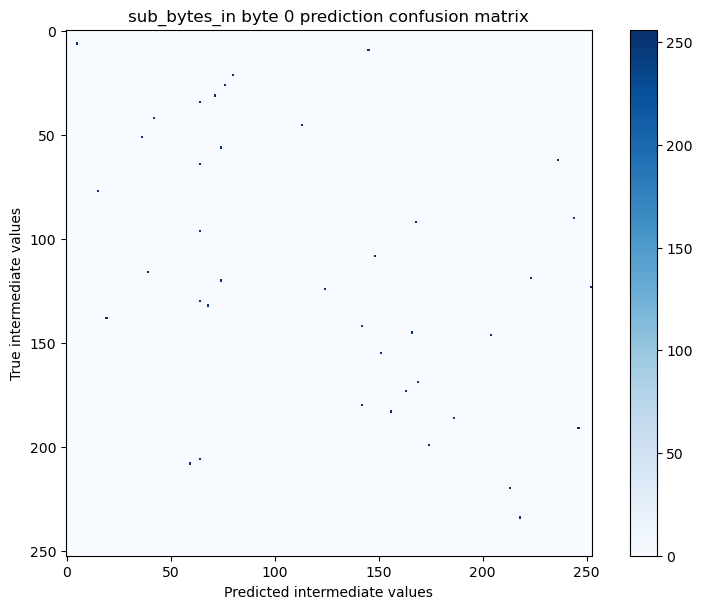

In [21]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))


In [22]:
config = """{
    "model": "cnn",
    "device": "stm32f415",
    "algorithm": "tinyaes",
    "version": "10",
    "attack_points": [
        "sub_bytes_out",
        "sub_bytes_in",
        "key"
    ],
    "attack_bytes": [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "10",
        "11",
        "12",
        "13",
        "14",
        "15"
    ],
    "max_trace_len": 20000,
    "num_shards": 256,
    "num_traces_per_shard": 256,
    "batch_size": 32,
    "epochs": 30,
    "optimizer_parameters": {
        "lr": 0.001,
        "multi_gpu_lr": 0.001
    },
    "model_parameters": {
        "activation": "relu",
        "initial_filters": 8,
        "initial_pool_size": 4,
        "block_kernel_size": 3,
        "blocks_stack1": 3,
        "blocks_stack2": 4,
        "blocks_stack3": 4,
        "blocks_stack4": 3,
        "dense_dropout": 0.1
    }
}"""
target_config = json.loads(config)


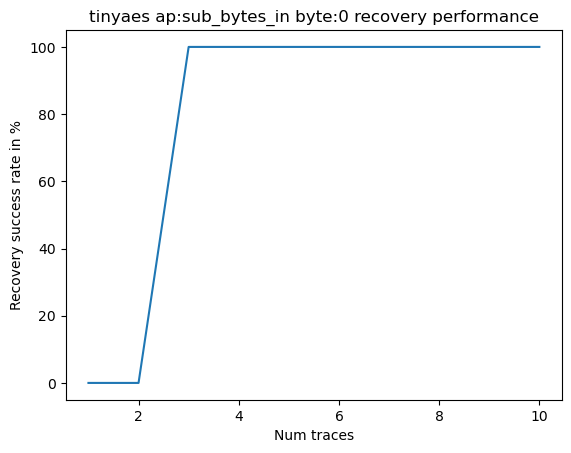

In [23]:
NUM_TRACES_TO_PLOT = 10
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % (target_config['algorithm'], ATTACK_POINT, ATTACK_BYTE))
plt.show()

In [25]:
min_traces = 0
max_traces = 0
cumulative_aa = 0
for idx, val in enumerate(y):
    cumulative_aa += val
    if not min_traces and val > 0:
        min_traces = idx + 1
    if not max_traces and val == 100.0:
        max_traces = idx + 1
        break

cumulative_aa = round( cumulative_aa / (idx + 1), 2) # divide by the number of steps

rows = [
    ["min traces", min_traces, round(y[min_traces -1 ], 1)],
    ["max traces", max_traces, round(y[max_traces - 1], 1)],
    ["cumulative score", cumulative_aa, '-']
]
print(tabulate(rows, headers=['metric', 'num traces', '% of keys']))

metric              num traces  % of keys
----------------  ------------  -----------
min traces                3     100.0
max traces                3     100.0
cumulative score         33.33  -


In [14]:
ATTACK_POINT = 'sub_bytes_in' # let's pick an attack point- Key is not a good target: it doesn't work for TinyAEs
TARGET_SHARD = 5 # a shard == a different key. Pick the one you would like
NUM_TRACES = 14  # how many traces to use - as seen in single byte, 5 traces is enough

In [15]:
# perfoming 16x the byte recovery algorithm showecased above - one for each key byte
real_key = [] # what we are supposed to find
recovered_key = [] # what we predicted
pb = tqdm(total=16, desc="guessing key", unit='guesses')
for ATTACK_BYTE in range(16):
    # data
    keys, pts, x, y = load_attack_shard(shard_paths[TARGET_SHARD], ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES, full_key=True)
    real_key.append(keys[0])
    x = x[:,:5000,:]
    # load model
    model = model5000

    # prediction
    predictions = model.predict(x)

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)

    # accumulating probabity
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)

    # order predictions by probability
    guess_ranks = (np.argsort(vals, )[-256:][::-1])

    # take strongest guess as our key guess
    recovered_key.append(guess_ranks[0])

    # update display
    pb.set_postfix({'Recovered key': bytelist_to_hex(recovered_key), "Real key": bytelist_to_hex(real_key)})
    pb.update()


pb.close()

guessing key:   0%|          | 0/16 [00:00<?, ?guesses/s]

NameError: name 'load_attack_shard' is not defined

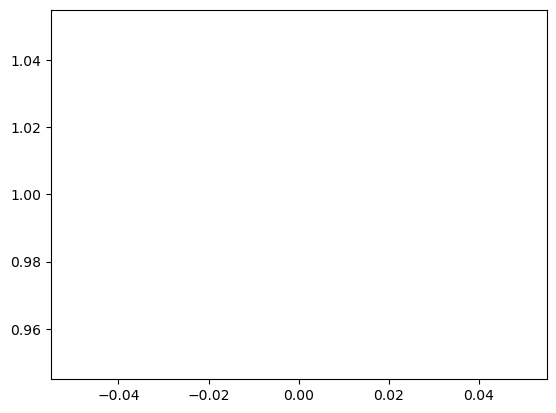

In [109]:
plt.plot(x[0])
plt.show()

AttributeError: 'int' object has no attribute 'shape'

In [1]:
#FEILSØKER METODEN
import src.DAT255_SCA.utils.dataset_utils as utils

file_path = "test_0.hdf5"
ATTACK_BYTE = 0
ATTACK_POINT = "sub_bytes_in"
NUM_TRACES = 10
x, y, keys, pts = utils.load_and_prepare_dataset_for_evaluation(file_path, ATTACK_BYTE, ATTACK_POINT, num_traces=NUM_TRACES)

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(10, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(10, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(10, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(10, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(10, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(10, 256), dtype=uint8)
tf.Tensor(
[[0 0 0 ... 0 0 0

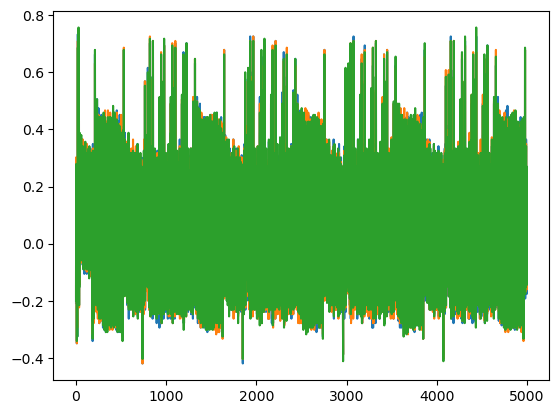

In [21]:
import matplotlib.pyplot as plt
plt.plot(x[0][0])
plt.plot(x[0][1])
plt.plot(x[0][2])

In [4]:
keys

[array([123, 123, 123, 123, 123, 123, 123, 123, 123, 123], dtype=uint8),
 array([57, 57, 57, 57, 57, 57, 57, 57, 57, 57], dtype=uint8),
 array([156, 156, 156, 156, 156, 156, 156, 156, 156, 156], dtype=uint8),
 array([48, 48, 48, 48, 48, 48, 48, 48, 48, 48], dtype=uint8),
 array([204, 204, 204, 204, 204, 204, 204, 204, 204, 204], dtype=uint8),
 array([41, 41, 41, 41, 41, 41, 41, 41, 41, 41], dtype=uint8),
 array([176, 176, 176, 176, 176, 176, 176, 176, 176, 176], dtype=uint8),
 array([167, 167, 167, 167, 167, 167, 167, 167, 167, 167], dtype=uint8),
 array([97, 97, 97, 97, 97, 97, 97, 97, 97, 97], dtype=uint8),
 array([189, 189, 189, 189, 189, 189, 189, 189, 189, 189], dtype=uint8),
 array([235, 235, 235, 235, 235, 235, 235, 235, 235, 235], dtype=uint8),
 array([105, 105, 105, 105, 105, 105, 105, 105, 105, 105], dtype=uint8),
 array([141, 141, 141, 141, 141, 141, 141, 141, 141, 141], dtype=uint8),
 array([84, 84, 84, 84, 84, 84, 84, 84, 84, 84], dtype=uint8),
 array([153, 153, 153, 153, 

In [30]:
keys[0]

array([123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
       123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
       123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
       123], dtype=uint8)

In [15]:
#noe er feil med nøklene


TypeError: list indices must be integers or slices, not tuple

In [12]:
pts[0][0]

224

In [10]:
utils.new_inspect(file_path)

test_0
traces
<HDF5 dataset "traces": shape (255, 5000, 1), type "<f4">
(255, 5000, 1) float32
(255, 5000, 1) float32
[[[-0.20784307]
  [ 0.27843142]
  [-0.03529406]
  ...
  [ 0.20784318]
  [ 0.19215691]
  [-0.05882347]]

 [[-0.18431365]
  [ 0.30196083]
  [-0.04313719]
  ...
  [ 0.22352946]
  [ 0.16078436]
  [-0.10588229]]

 [[-0.19999993]
  [ 0.27843142]
  [-0.02745092]
  ...
  [ 0.22352946]
  [ 0.17647064]
  [-0.10588229]]

 ...

 [[-0.19215679]
  [ 0.28627455]
  [-0.02745092]
  ...
  [ 0.21568632]
  [ 0.16078436]
  [-0.09803915]]

 [[-0.2156862 ]
  [ 0.28627455]
  [-0.05098033]
  ...
  [ 0.22352946]
  [ 0.16078436]
  [-0.09803915]]

 [[-0.19215679]
  [ 0.27058828]
  [-0.05882347]
  ...
  [ 0.22352946]
  [ 0.19215691]
  [-0.09019601]]]
key
<HDF5 dataset "key": shape (16, 255), type "|u1">
(16, 255) uint8
(16, 255) uint8
[[123 123 123 ... 123 123 123]
 [212 212 212 ... 212 212 212]
 [ 64  64  64 ...  64  64  64]
 ...
 [ 71  71  71 ...  71  71  71]
 [173 173 173 ... 173 173 173]
 [ 84 

In [ ]:
#Her er de tre først nøklene so vi forventer å finne i gruppe 1, 2 og 3
[123 212  64 231 103 136  38 171 145  68 207 235  35  71 173  84]
[ 57 170 230  85  32 242 235  10  99 189  98  40 225  24  61 217]
[ 47 214  59 232 208  22  62  83 138 221  47  92 206 241  13 118]
